In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as dt
import json

## 퀀트함수
from quant_functions import anal_funcs, data_funcs
import portfolio_obtimizer
import myfuncs
from fredapi import Fred
fred = Fred(api_key='cfb4f49f5c1a9396f671b8049d992e56')

# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')
import plotly.graph_objects as go
import seaborn as sns
sns.set_style('whitegrid')
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mticker
from matplotlib.ticker import LogLocator
import matplotlib.pyplot as plt
## figure size 설정
figsize=(12, 8)
plt.rcParams["figure.figsize"] = figsize
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

import graphModule as gm

## color 설정
with open('colors.json') as f:
    mycolors = json.load(f)

# 블루 테마
cmap_colors = ["#FFFFFF", mycolors['color_cont3'], mycolors['color_cont2']]
# LinearSegmentedColormap 생성
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", cmap_colors, N=256)    

## shock case
with open('shockCase.json', encoding='utf-8') as f:
    shock_cases = json.load(f)

## Data Load

In [2]:
highlight_periods = [(shock_cases['1차오일쇼크_t0'], shock_cases['1차오일쇼크_t1']),
                     (shock_cases['2차오일쇼크_t0'], shock_cases['2차오일쇼크_t1']),
                     (shock_cases['물가충격_t0'], shock_cases['물가충격_t1']),
                     (shock_cases['걸프전_t0'], shock_cases['걸프전_t1']),
                     (shock_cases['닷컴버블_t0'], shock_cases['닷컴버블_t1']),
                     (shock_cases['금융위기_t0'], shock_cases['금융위기_t1']),
                     (shock_cases['코로나_t0'], shock_cases['코로나_t1'])]

In [3]:
## 보간용 필수 데이터
gold = pd.read_csv(f"gold.csv", encoding='utf-8').set_index('Date')[['Close']].rename(columns={'Close':'Gold'})
gold.index = pd.to_datetime(gold.index)
ds20 = fred.get_series('DGS20')
ds10 = fred.get_series('DGS10')

## load data
df_ref = data_funcs.get_merged_df('^IXIC', '^GSPC', '^DJI', 'GC=F')
df_ref = df_ref.fillna(method = 'pad')
df_ref['Gold'] = gold['Gold']
df_ref['DGS10'] = ds10
df_ref['DGS20'] = ds20

## Imputation
df_ref = myfuncs.imputation(df_ref, '^GSPC', '^DJI')
df_ref = myfuncs.imputation(df_ref, 'DGS10', 'DGS20')
df_ref = myfuncs.imputation(df_ref, 'DGS20', 'DGS10')
df_ref = myfuncs.imputation(df_ref, 'GC=F', 'Gold')
df_ref['Gold']['1975-01-02'] = 1
df_ref['Gold']['1975-01-03'] = 1

## column selection
df_ref = df_ref[['^GSPC', '^DJI', '^IXIC', 'DGS10', 'DGS20', 'Gold']]
df_ref.columns = ['S&P500', 'DowJones', 'NASDAQ', 'DGS10', 'DGS20', 'Gold']

## 75년 이전에는 Gold 데이터가 없음
df_ref = df_ref['1975':]
df_ref = df_ref/df_ref.iloc[0]

[*********************100%%**********************]  4 of 4 completed


0.9189325071249966
0.7566303173418912
1.1913424214693302
0.9953424146502147


In [4]:
## 프로젝트마다 필요한 데이터
tickers = ['QQQ', 'QLD', 'TQQQ']
df_ori = data_funcs.get_merged_df(*tickers)
df_ori = df_ori[tickers]

[*********************100%%**********************]  3 of 3 completed


In [5]:
## 보간 시계열 데이터
df_imp = pd.concat([df_ref, df_ori], axis=1)
df_imp = myfuncs.imputation(df_imp, 'NASDAQ', 'QQQ')
df_imp = myfuncs.imputation(df_imp, 'QQQ', 'QLD')
df_imp = myfuncs.imputation(df_imp, 'QLD', 'TQQQ')

## 비보간 시계열 데이터
df_cut = df_ori.dropna()
df_cut = df_cut/df_cut.iloc[0]

1.0449131682460506
1.989873950874533
1.4885109537810535


## Visualization

In [6]:
assets = ['QQQ', 'QLD', 'TQQQ']

In [7]:
df_imp_m = df_imp[assets].resample('M').last()
rets_imp_m = df_imp_m.pct_change().fillna(0)

In [8]:
rets_imp = df_imp.pct_change().fillna(0)

In [54]:
win_ratio = anal_funcs.get_odds_df(rets_imp_m, rf = 0)['odds']['TQQQ']
return_rate = rets_imp_m['TQQQ'][rets_imp_m['TQQQ']>0].mean()
loss_rate = np.abs(rets_imp_m['TQQQ'][rets_imp_m['TQQQ']<0].mean())

In [89]:
seed = 100
steps = 12*10
simulations = 1000

In [90]:
kelly_value = anal_funcs.cal_kelly_value(win_ratio, loss_rate, return_rate)

In [91]:
result = anal_funcs.monte_carlo_simulation(win_ratio, loss_rate, return_rate, seed, steps, simulations, bet_ratio=1)

In [92]:
result.min().min(), result.max().max()

(0.6224183054133844, 47599.4072302712)

In [93]:
paths = np.array(result.T)

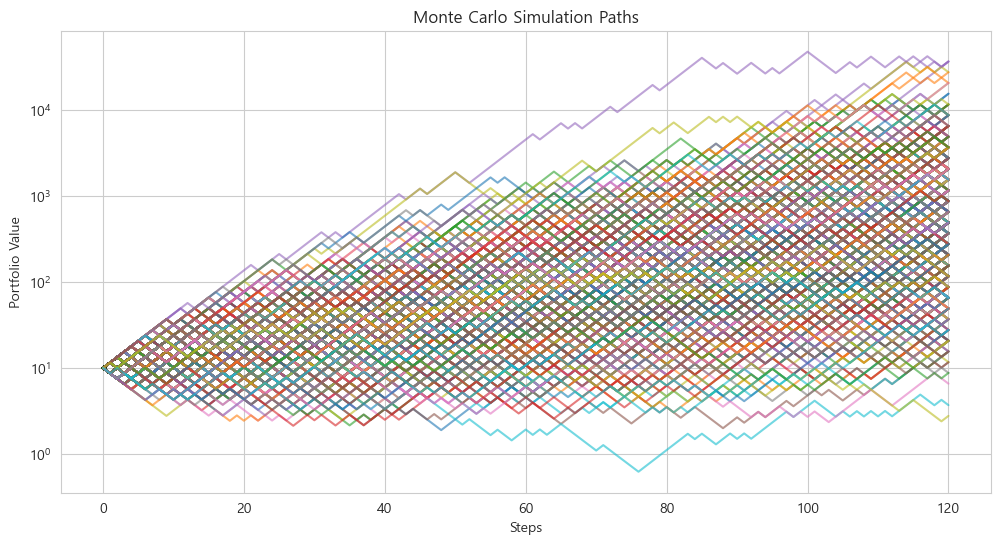

In [94]:
# 경로 시각화
plt.figure(figsize=(12, 6))
for path in paths:
    plt.plot(path, alpha=0.6)  # 각 경로 그리기
plt.axhline(0, color='black', linestyle='--', linewidth=1, label="Zero Line")
plt.title("Monte Carlo Simulation Paths")
plt.xlabel("Steps")
plt.ylabel("Portfolio Value")
plt.yscale('log')
plt.show()

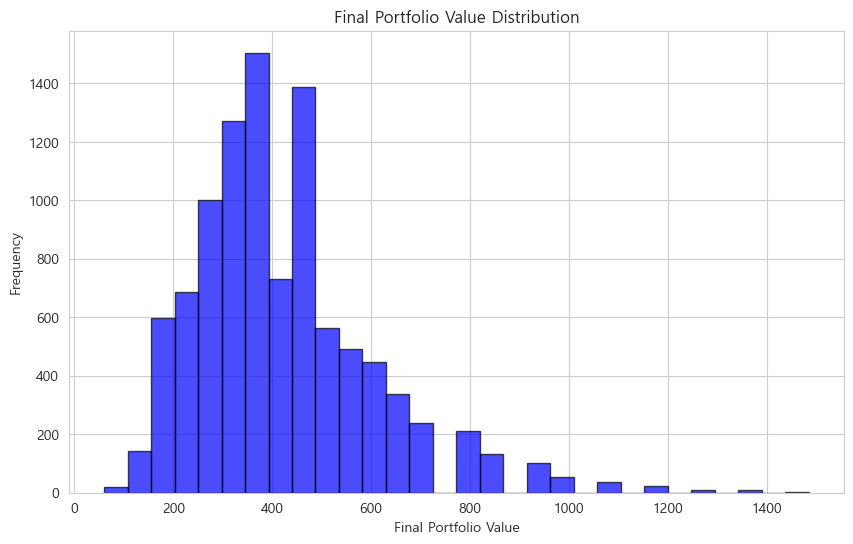

In [62]:
final_values = paths[:, -1]

# 히스토그램
plt.figure(figsize=(10, 6))
plt.hist(final_values, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title("Final Portfolio Value Distribution")
plt.xlabel("Final Portfolio Value")
plt.ylabel("Frequency")
plt.show()

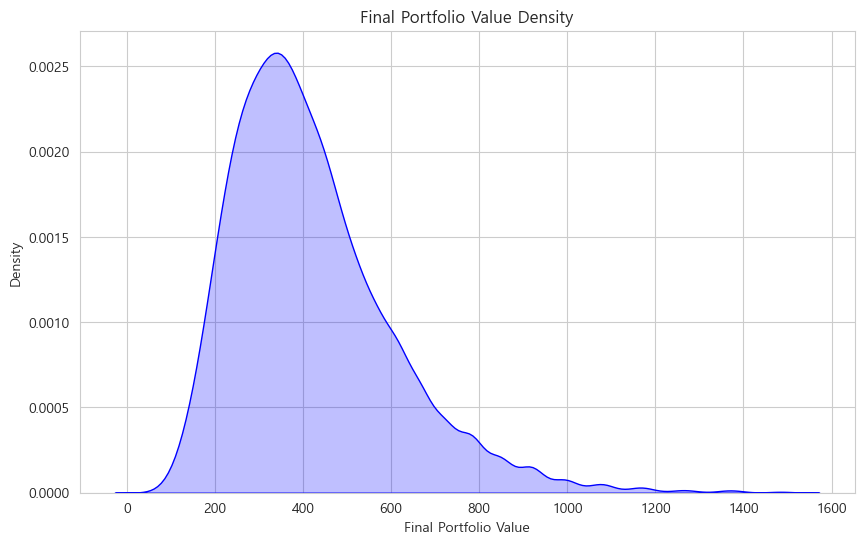

In [63]:
# 확률 밀도 함수
plt.figure(figsize=(10, 6))
sns.kdeplot(final_values, shade=True, color='blue')
plt.title("Final Portfolio Value Density")
plt.xlabel("Final Portfolio Value")
plt.ylabel("Density")
plt.show()

In [64]:
simulations = len(paths)

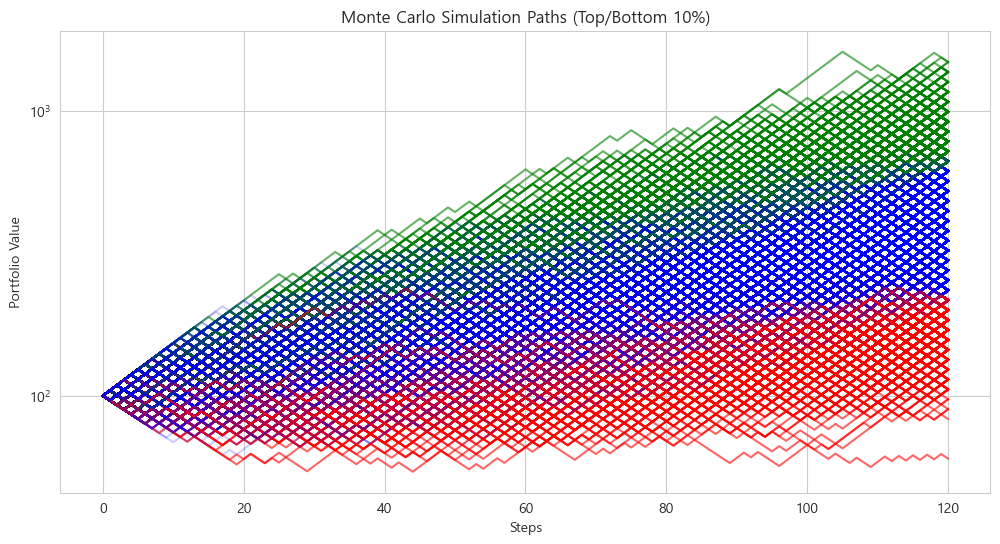

In [74]:
# 상위 10%와 하위 10% 추출
sorted_paths = np.sort(paths[:, -1])
top_10_percent = sorted_paths[-int(simulations * 0.1):]
bottom_10_percent = sorted_paths[:int(simulations * 0.1)]

# 시각화
plt.figure(figsize=(12, 6))
for i, path in enumerate(paths):
    if path[-1] in top_10_percent:
        plt.plot(path, color='green', alpha=0.6)  # 상위 10%
    elif path[-1] in bottom_10_percent:
        plt.plot(path, color='red', alpha=0.6)  # 하위 10%
    else:
        plt.plot(path, color='blue', alpha=0.2)

plt.axhline(0, color='black', linestyle='--', linewidth=1, label="Zero Line")
plt.title("Monte Carlo Simulation Paths (Top/Bottom 10%)")
plt.xlabel("Steps")
plt.ylabel("Portfolio Value")
plt.yscale('log')
plt.show()

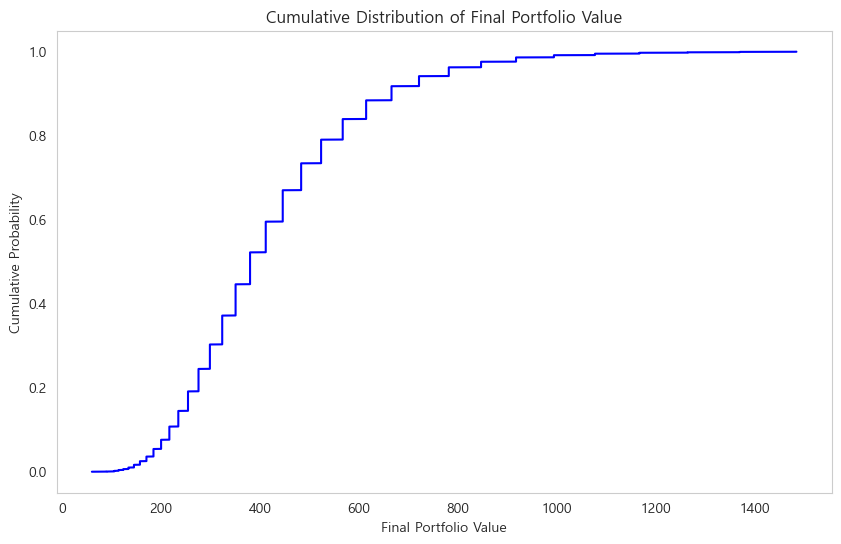

In [66]:
# 누적 분포
sorted_values = np.sort(final_values)
cumulative_probs = np.linspace(0, 1, len(sorted_values))

plt.figure(figsize=(10, 6))
plt.plot(sorted_values, cumulative_probs, label="CDF", color='blue')
plt.title("Cumulative Distribution of Final Portfolio Value")
plt.xlabel("Final Portfolio Value")
plt.ylabel("Cumulative Probability")
plt.grid()
plt.show()

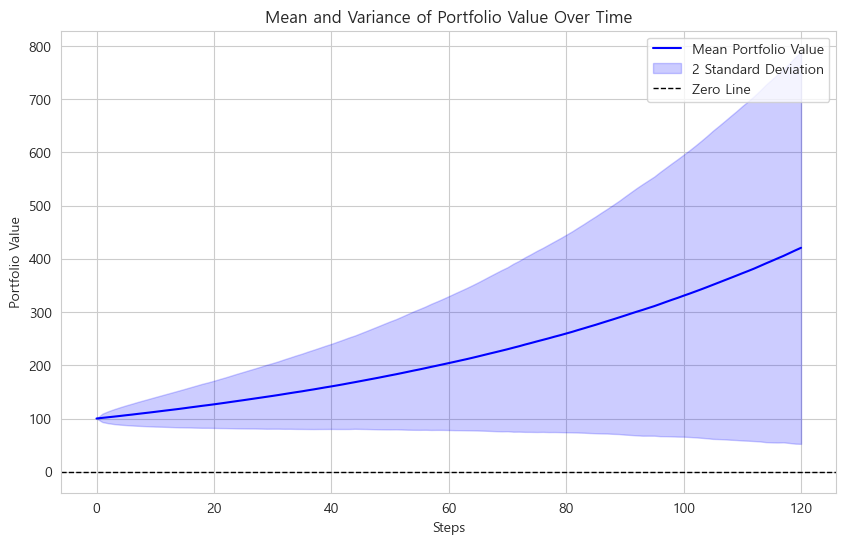

In [73]:
# 단계별 평균과 분산
mean_values = np.mean(paths, axis=0)
std_values = np.std(paths, axis=0)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(mean_values, label="Mean Portfolio Value", color='blue')
plt.fill_between(range(paths.shape[1]), mean_values - 2*std_values, mean_values + 2*std_values, 
                 color='blue', alpha=0.2, label="2 Standard Deviation")
plt.axhline(0, color='black', linestyle='--', linewidth=1, label="Zero Line")
plt.title("Mean and Variance of Portfolio Value Over Time")
plt.xlabel("Steps")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()